# Composer Identification using Deep Learning

## Problem Statement

The classification of composers of classical music songs, especially from MIDI files, is a major challenge for new musicians, listeners, and fans because of the slight stylistic variation between composers like Bach, Beethoven, Chopin, and Mozart.

Challenge: The traditional approach is highly dependent on manual experience, which is time-consuming and subjective, and there are no automated tools that can correctly classify these compositions.

This project solves the problem through the creation of a deep learning solution, employing
- Convolutional Neural Network (CNN) and
- Long Short-Term Memory (LSTM) architectures

This will predict automatically the composer of a specified MIDI file based on a dataset of Bach, Beethoven, Chopin, and Mozart compositions.

Objective: Developing a strong model that scores high accuracy, precision, and recall to offer a consistent tool for music classification and enhancing accessibility to music analysis.

## Dataset


The project uses a Kaggle dataset containing MIDI files from composers Bach, Beethoven, Chopin, and Mozart.

Link: https://www.kaggle.com/datasets/blanderbuss/midi-classic-music

## Setup & Configuration

In [ ]:
!pip install -q keras_tuner pretty_midi imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 65.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import pretty_midi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, BatchNormalization, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Clean existing directory and unzip with overwrite /content/midiclassics.zip
!rm -rf /content/midiclassics
!mkdir /content/midiclassics
!unzip -o /content/midiclassics.zip -d /content/midiclassics

In [ ]:
import os

BASE_DATA_PATH = r'midiclassics'
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
OUTPUT_DIR = 'project_output'
OUTPUT_DIR1 = 'project_output1'
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Data Loading

In [ ]:
def load_midi_files_revised(base_path, target_composers):
    """
    Loads all MIDI files, including those in subdirectories,
    for each target composer.
    """
    all_files = []
    print("--- Starting file search ---")
    for composer in target_composers:
        composer_path = os.path.join(base_path, composer)
        if not os.path.isdir(composer_path):
            print(f"Warning: Directory not found for '{composer}'")
            continue
        print(f"Searching for files in: {composer_path}")
        for root, dirs, files in os.walk(composer_path):
            for file in sorted(files):
                if file.lower().endswith(('.mid', '.midi')):
                    all_files.append({
                        'path': os.path.join(root, file),
                        'composer': composer
                    })
    if not all_files:
        print("\nCRITICAL WARNING: No MIDI files were found! Check your BASE_DATA_PATH.")
    return pd.DataFrame(all_files)


In [ ]:
df = load_midi_files_revised(BASE_DATA_PATH, TARGET_COMPOSERS)
print("\n--- Final File Counts ---")
print(df['composer'].value_counts())

--- Starting file search ---
Searching for files in: midiclassics/Bach
Searching for files in: midiclassics/Beethoven
Searching for files in: midiclassics/Chopin
Searching for files in: midiclassics/Mozart

--- Final File Counts ---
composer
Bach         1024
Mozart        257
Beethoven     213
Chopin        136
Name: count, dtype: int64


## Feature Extraction

In [ ]:
def extract_musical_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        notes = [note for instrument in midi_data.instruments for note in instrument.notes if not instrument.is_drum]
        if not notes: return None
        total_duration = midi_data.get_end_time()
        if total_duration == 0: return None

        pitches = [n.pitch for n in notes]
        velocities = [n.velocity for n in notes]
        durations = [n.end - n.start for n in notes]
        intervals = [abs(notes[i+1].pitch - notes[i].pitch) for i in range(len(notes)-1) if notes[i+1].start == notes[i].start]

        piano_roll = midi_data.get_piano_roll(fs=20)
        polyphony = np.mean(np.sum(piano_roll > 0, axis=0)) if piano_roll.shape[1] > 0 else 0

        # --- NEW FEATURES ---
        tempo = midi_data.estimate_tempo()
        duration_variance = np.var(durations) if durations else 0

        features = {
            'num_instruments': len(midi_data.instruments),
            'note_density': len(notes) / total_duration,
            'polyphony': polyphony,
            'pitch_mean': np.mean(pitches) if pitches else 0,
            'pitch_variance': np.var(pitches) if pitches else 0,
            'velocity_mean': np.mean(velocities) if velocities else 0,
            'velocity_variance': np.var(velocities) if velocities else 0,
            'duration_mean': np.mean(durations) if durations else 0,
            'duration_variance': duration_variance,
            'avg_pitch_interval': np.mean(intervals) if intervals else 0,
            'estimated_tempo': tempo,
        }
        return features
    except Exception as e:
        print(f"Could not process {midi_path}: {e}")
        return None

### Feature Processing

In [ ]:
features_csv_path = os.path.join(OUTPUT_DIR, 'musical_features_enhanced.csv')

In [ ]:
if os.path.exists(features_csv_path):
    print("\n--- Loading pre-extracted features from file... ---")
    feature_df = pd.read_csv(features_csv_path)
else:
    print("\n--- No feature file found. Extracting features from all MIDI files... ---")
    all_features = []
    for index, row in df.iterrows():
        features = extract_musical_features(row['path'])
        if features:
            features['composer'] = row['composer']
            all_features.append(features)
    feature_df = pd.DataFrame(all_features).dropna()
    feature_df.to_csv(features_csv_path, index=False)


--- Loading pre-extracted features from file... ---


In [ ]:
print("Feature processing complete. Shape of feature DataFrame:", feature_df.shape)
print("Features used:", feature_df.columns.tolist())

Feature processing complete. Shape of feature DataFrame: (1628, 12)
Features used: ['num_instruments', 'note_density', 'polyphony', 'pitch_mean', 'pitch_variance', 'velocity_mean', 'velocity_variance', 'duration_mean', 'duration_variance', 'avg_pitch_interval', 'estimated_tempo', 'composer']


## Exploratory Data Analysis (EDA)

### 1. Distribution of Composers (Class Imbalance)

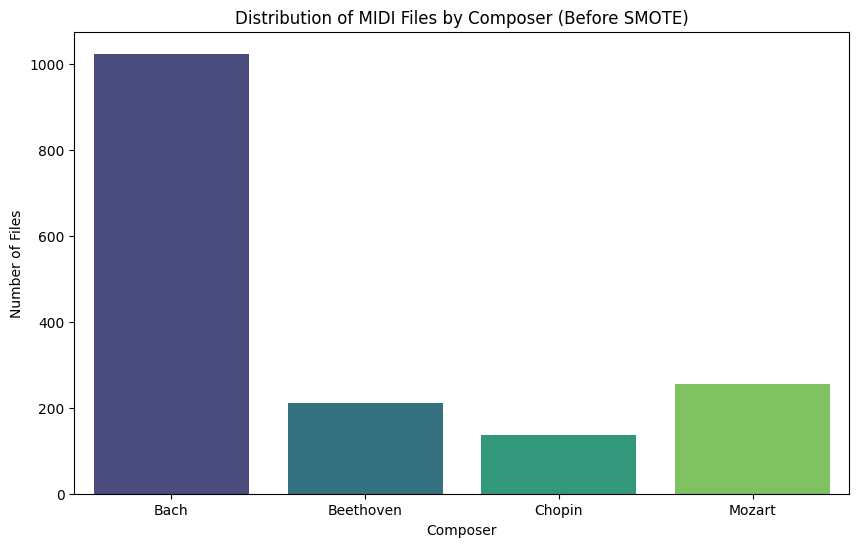

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=feature_df, x='composer', order=TARGET_COMPOSERS, hue='composer', palette='viridis')
plt.title('Distribution of MIDI Files by Composer (Before SMOTE)')
plt.xlabel('Composer')
plt.ylabel('Number of Files')
plt.show()

### 1. Analysis of Composer Distribution (Class Imbalance)

**Observation:**
The bar chart above immediately reveals a significant **class imbalance** in the dataset.

- The **'Bach'** class is heavily over-represented, with over 1000 MIDI files.
- In contrast, **'Beethoven'**, **'Mozart'**, and especially **'Chopin'** are minority classes.

**Implication for Modeling:**
This imbalance is a critical issue. If we were to train a model on this raw data, it would likely develop a strong bias towards the majority class (Bach). I

**Justification for SMOTE:**
This plot provides a clear justification for using the **Synthetic Minority Over-sampling TEchnique (SMOTE)** on our training data. By generating synthetic samples for the minority classes, we can create a balanced training set. This ensures a more robust and fair classifier.

### 2. Feature Distributions by Composer

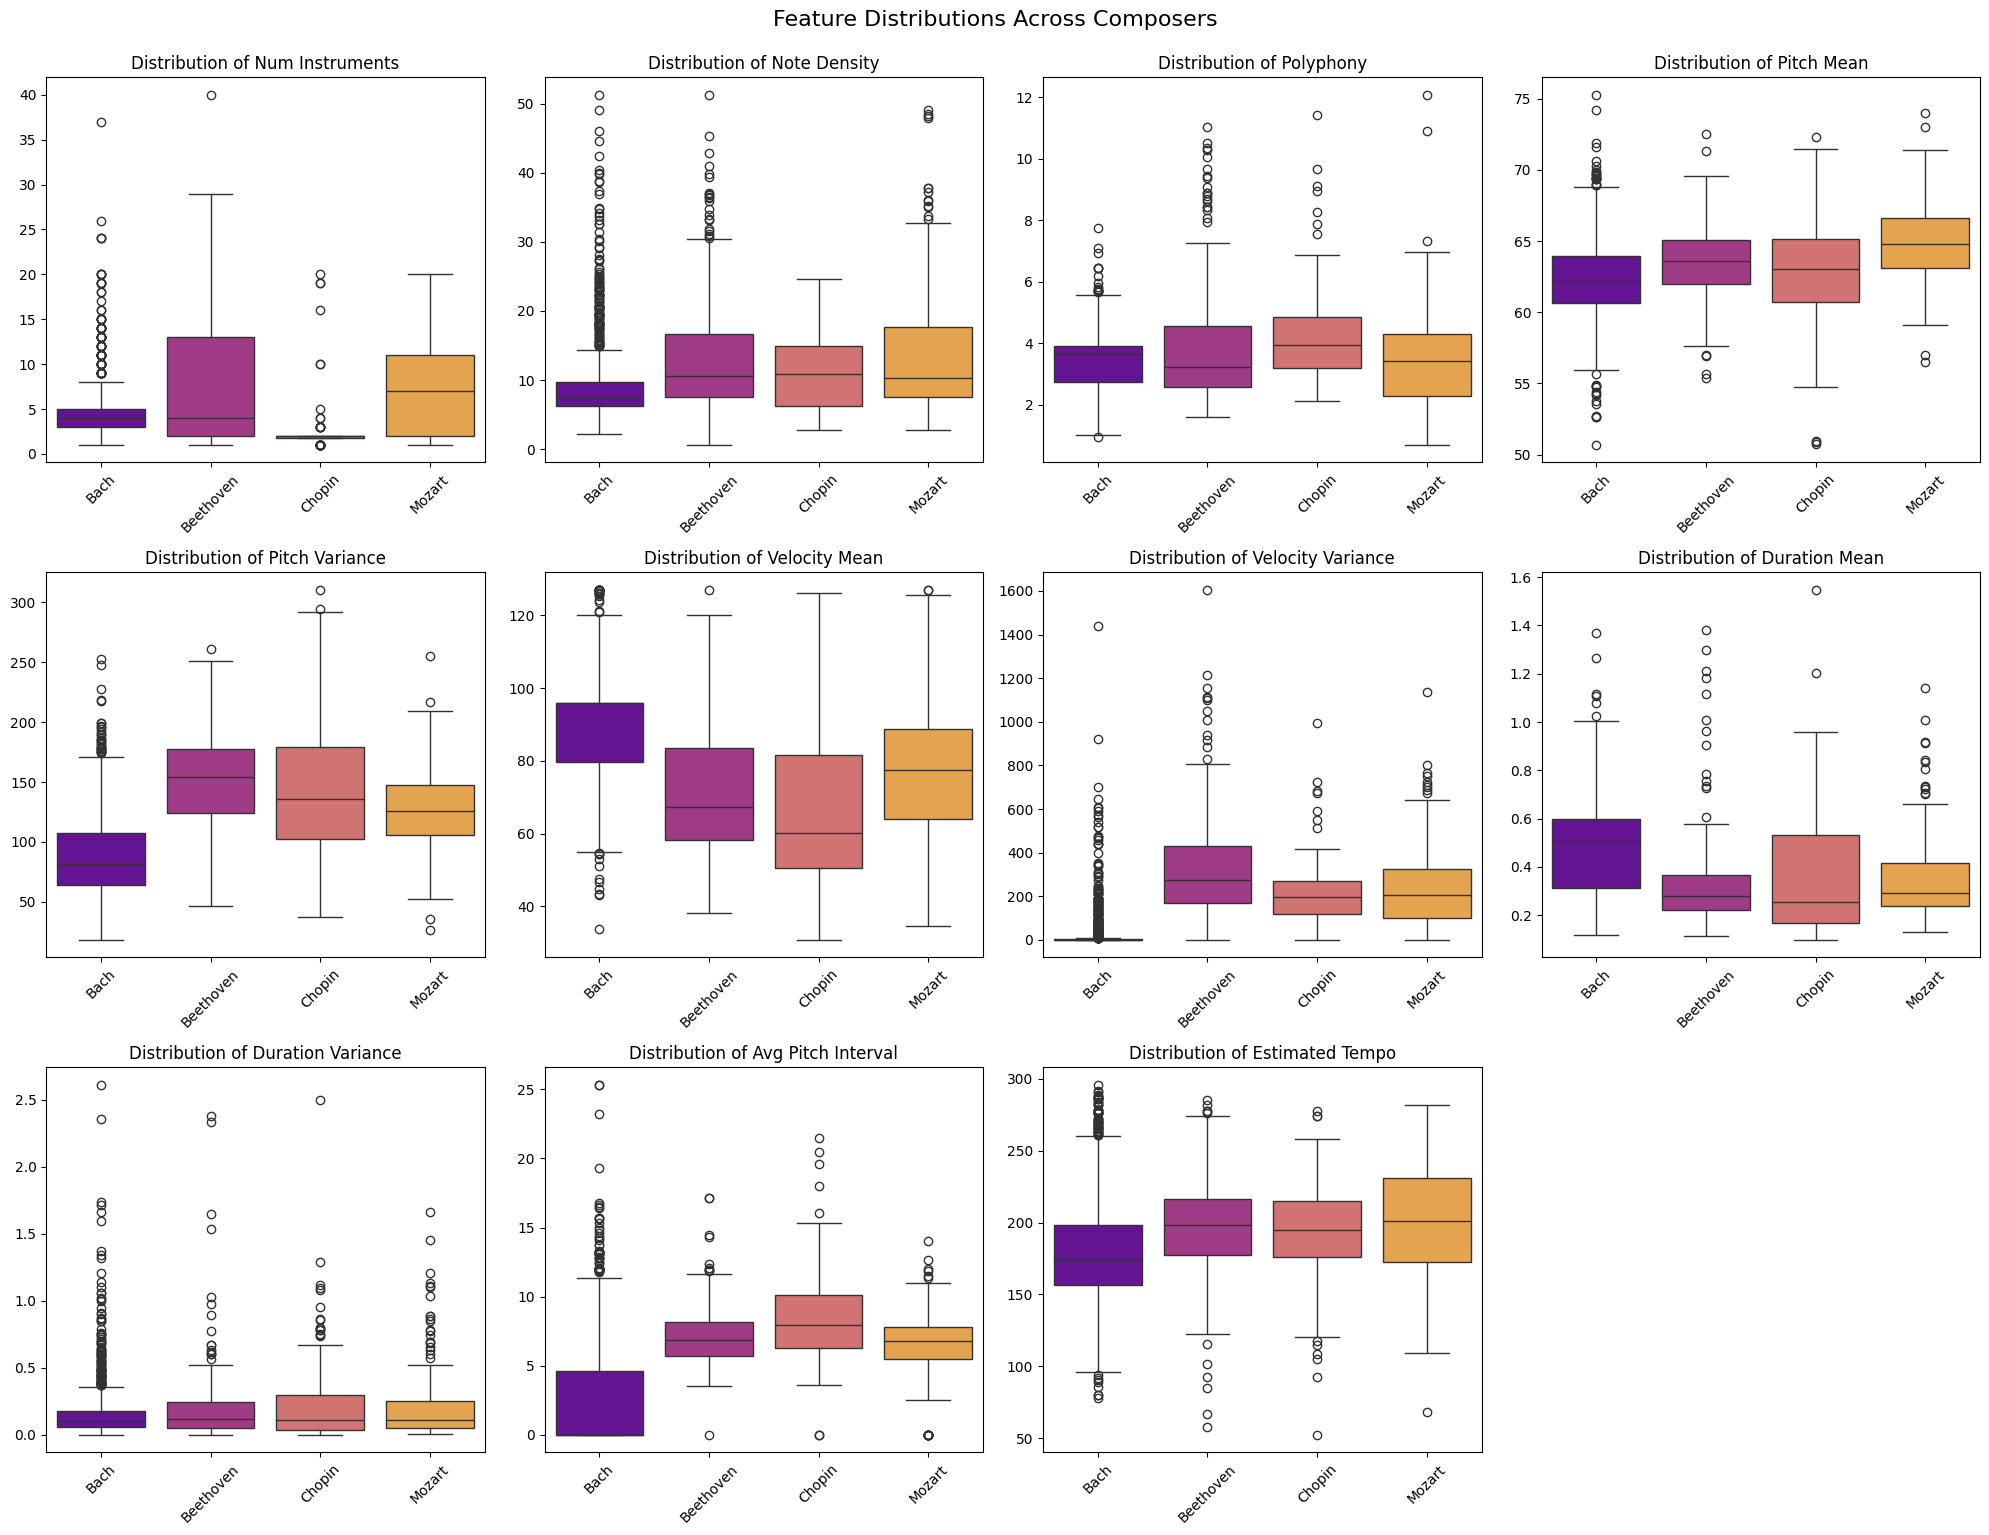

In [ ]:
features_to_plot = feature_df.drop('composer', axis=1).columns
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    sns.boxplot(data=feature_df, x='composer', y=feature, order=TARGET_COMPOSERS, hue='composer', ax=axes[idx], palette='plasma')
    axes[idx].set_title(f'Distribution of {feature.replace("_", " ").title()}')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')
    axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Feature Distributions Across Composers', y=1.02, fontsize=16)
plt.show()

### 3. Violin Plots for Feature Density

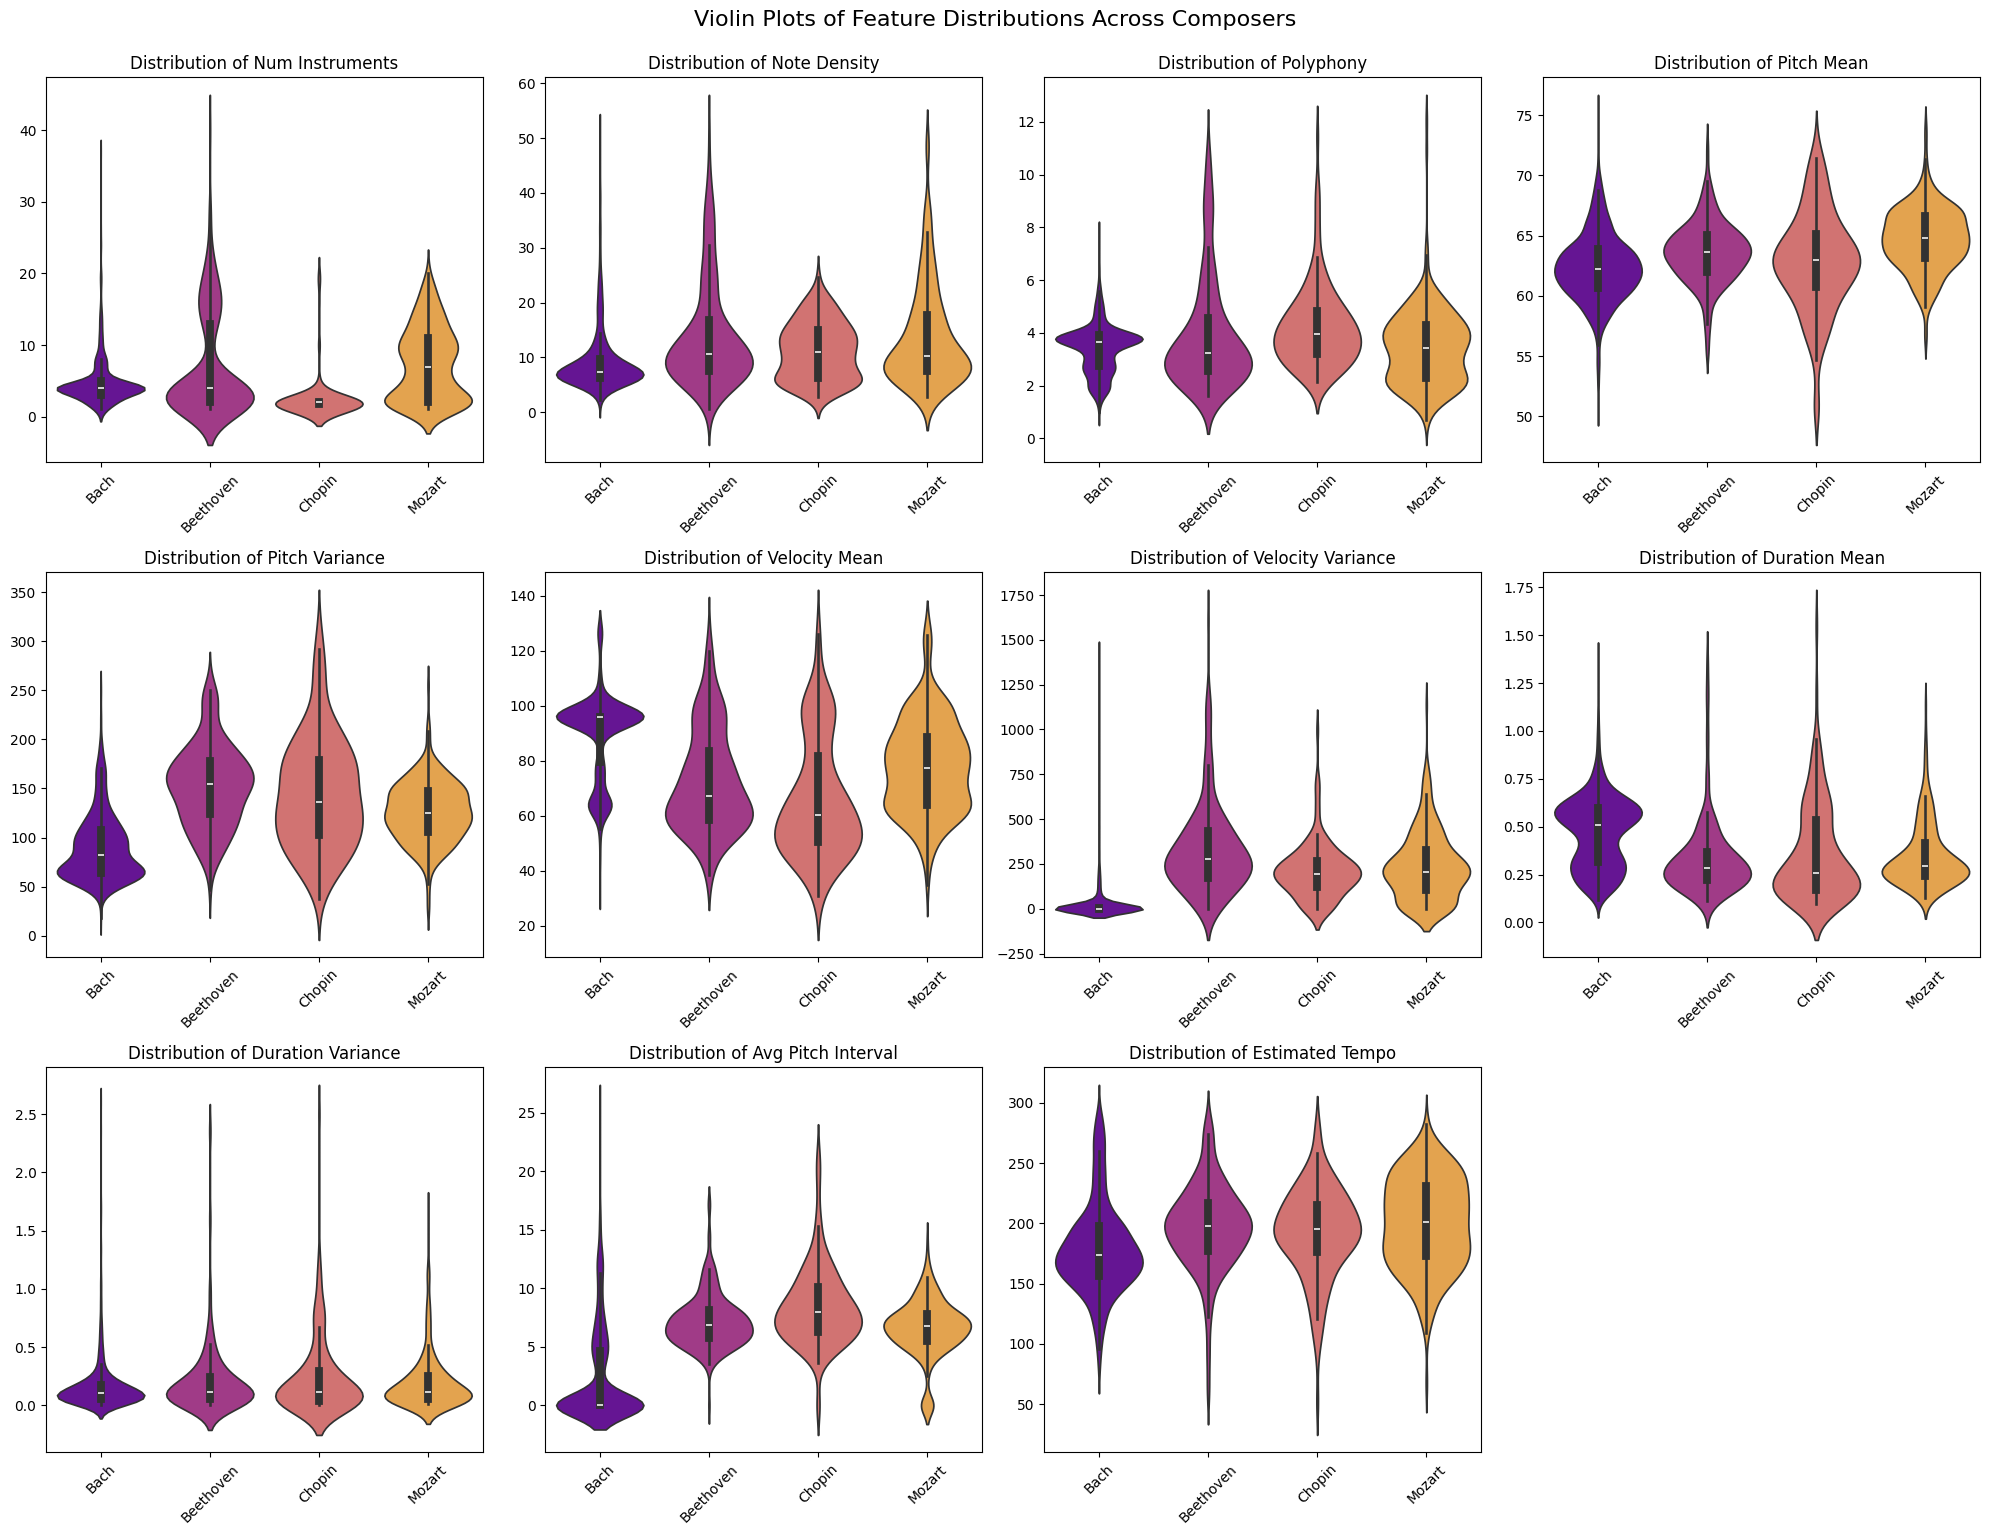

In [ ]:
features_to_plot = feature_df.drop('composer', axis=1).columns
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    sns.violinplot(data=feature_df, x='composer', y=feature, order=TARGET_COMPOSERS, hue='composer', ax=axes[idx], palette='plasma')
    axes[idx].set_title(f'Distribution of {feature.replace("_", " ").title()}')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')
    axes[idx].tick_params(axis='x', rotation=45)

for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Violin Plots of Feature Distributions Across Composers', y=1.02, fontsize=16)
plt.show()

From both box and violin plots, following key observations are made:
- **`Velocity`**: Bach stands out with a significantly higher median velocity and a more compact distribution. This suggests his pieces in this dataset are played with a more consistent and forceful touch
- **`Num Instruments` & `Polyphony`:** Beethoven's works show a much wider range and higher median for the number of instruments and polyphony. Chopin has low instrument count.
- **`Duration Variance`:** Mozart exhibits a noticeably lower variance in note durations.
- **`Note Density`:** Beethoven appears to have a slightly higher median note density compared to the others.
- Features like **`Pitch Mean`** and **`Estimated Tempo`** show considerable overlap across all composers. While their medians differ slightly, their distributions are largely similar.

### 4. Correlation Heatmap

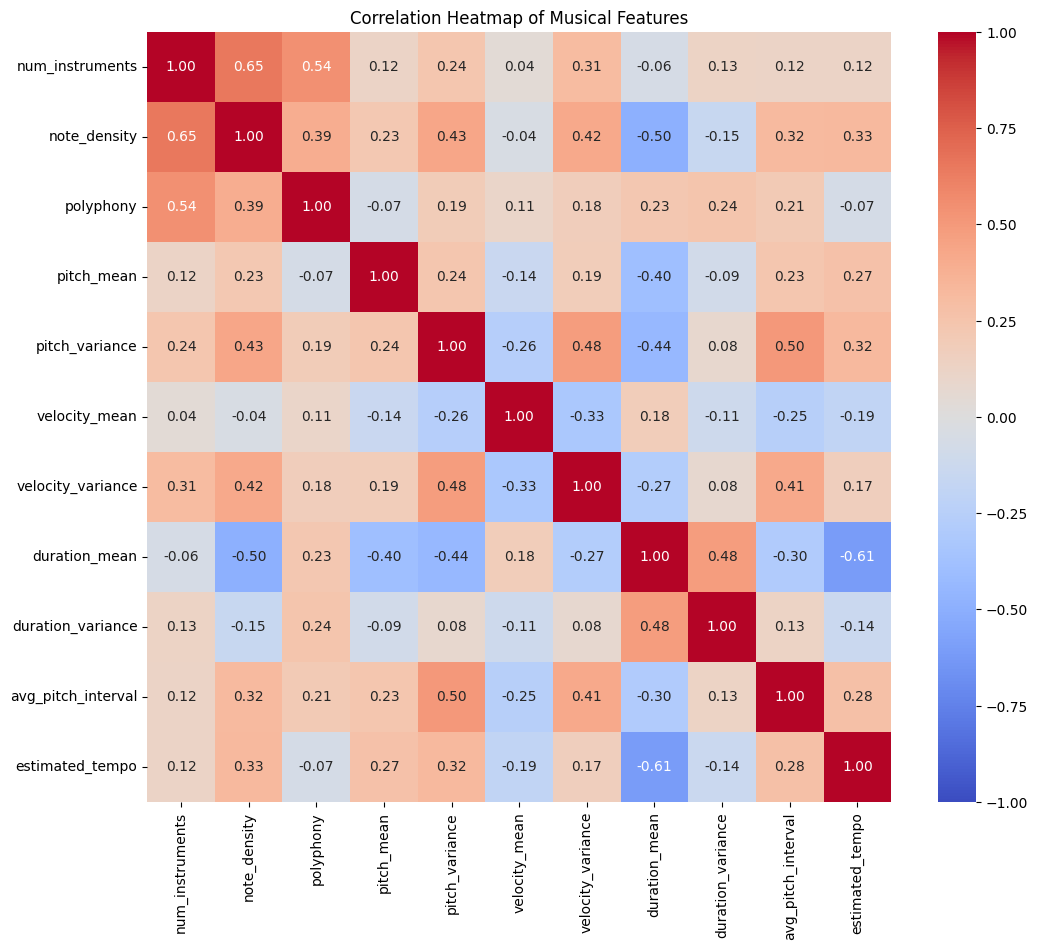

In [ ]:
plt.figure(figsize=(12, 10))
corr = feature_df.drop('composer', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Musical Features')
plt.show()

**Key Observations:**

*   **Strongest Correlation (Negative):** The most significant correlation is between **`estimated_tempo`** and **`duration_mean` (-0.61)**.

*   **Strong Positive Correlation:** A strong positive correlation exists between **`note_density`** and **`num_instruments` (0.65)**.

*   **Other Moderate Correlations:** We also observe a moderate negative relationship between **`note_density`** and **`duration_mean` (-0.50)**.

There are no extremely high values (e.g., > 0.9 or < -0.9) that would suggest severe redundancy between features. This signifies that each feature likely provides some unique information for the model.

## Data Preparation For Model

In [ ]:
X = feature_df.drop('composer', axis=1)
y = feature_df['composer']

In [ ]:
# Stratified split to maintain composer proportions in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Data Augmentation via SMOTE to Handle Class Imbalance

The EDA showed a major class imbalance. To solve this, we use SMOTE as our data augmentation technique. It generates new, synthetic data points for the minority classes, creating a balanced and richer training set. This is a crucial step to prevent model bias and improve overall generalization.

In [ ]:
# Use SMOTE to handle class imbalance in the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

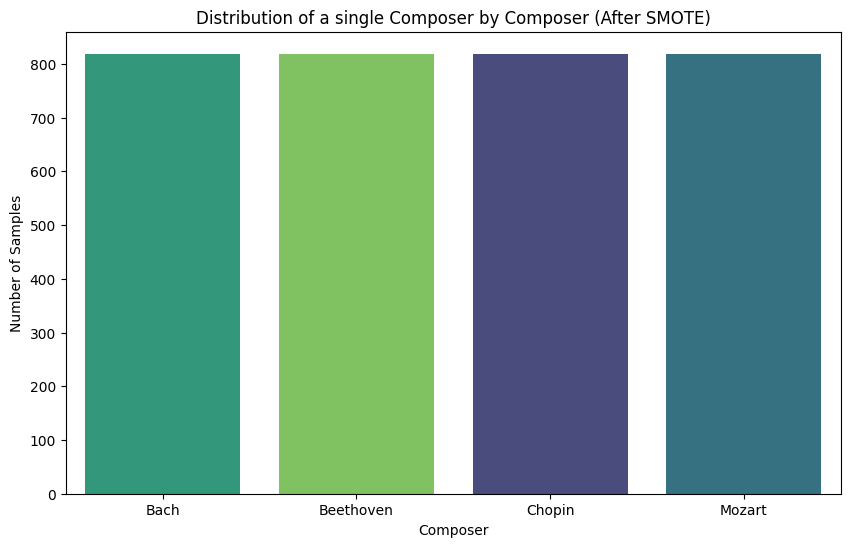

In [ ]:
# Visualize class distribution AFTER SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled, order=TARGET_COMPOSERS, hue=y_train_resampled, palette='viridis')
plt.title('Distribution of a single Composer by Composer (After SMOTE)')
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.show()

- Each of the four classes (Bach, Beethoven, Chopin, and Mozart) now contains an equal number of samples, approximately 820 each.
- SMOTE achieved this by identifying the majority class ('Bach') and then generating new, synthetic data points for the minority classes ('Beethoven', 'Chopin', 'Mozart') until they reached the same size as the majority class.

In [ ]:
# Scale features after resampling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Encode labels to integers and then to one-hot vectors
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)


In [ ]:
# Reshape data for 1D-CNN: (samples, features, 1)
num_features = X_train_scaled.shape[1]
X_train_cnn1d = X_train_scaled.reshape((X_train_scaled.shape[0], num_features, 1))
X_test_cnn1d = X_test_scaled.reshape((X_test_scaled.shape[0], num_features, 1))

In [ ]:
print(f"\nReshaped data for 1D-CNN. New shape: {X_train_cnn1d.shape}")


Reshaped data for 1D-CNN. New shape: (3276, 11, 1)


## Model Building - CNN Architecture

In [ ]:
from tensorflow.keras.regularizers import l2

def build_custom_cnn_model(input_shape, num_classes, learning_rate=0.001):
    """
    A custom-designed 'pyramid' style CNN
    """
    model = Sequential([
        Input(shape=input_shape),

        # Convolutional Block 1
        # Starts with fewer filters to capture basic feature interactions.
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),

        # Convolutional Block 2
        # Increase filters to combine patterns from the previous layer.
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3), # Add dropout after the second conv block

        # Convolutional Block 3
        # Final conv layer with more filters for higher-level abstractions.
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),

        # Summarize the feature maps
        GlobalAveragePooling1D(),

        # Dense Classifier
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate custom model with a starting learning rate
custom_model = build_custom_cnn_model(
    input_shape=(num_features, 1),
    num_classes=num_classes,
    learning_rate=0.001  # Let's start with a standard learning rate
)

custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,908 (390.27 KB)

 Trainable params: 98,692 (385.52 KB)

 Non-trainable params: 1,216 (4.75 KB)

### Train Model

In [ ]:
print("\n--- Training the Custom-Designed CNN Model ---")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

history_custom = custom_model.fit(
    X_train_cnn1d, y_train_cat,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_cnn1d, y_test_cat),
    callbacks=[early_stopping, reduce_lr]
)




--- Training the Custom-Designed CNN Model ---
Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4383 - loss: 2.1760 - val_accuracy: 0.0828 - val_loss: 2.1834 - learning_rate: 0.0010
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5439 - loss: 1.7062 - val_accuracy: 0.1564 - val_loss: 2.1906 - learning_rate: 0.0010
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6435 - loss: 1.4335 - val_accuracy: 0.3773 - val_loss: 1.9473 - learning_rate: 0.0010
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6755 - loss: 1.3069 - val_accuracy: 0.6074 - val_loss: 1.4070 - learning_rate: 0.0010
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7062 - loss: 1.2027 - val_accuracy: 0.6902 - val_loss: 1.2202 - learning_rate: 0.0010
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7408 - loss: 1.1392 - val_accuracy: 0.7178 - val_loss: 1.1159 - learning_rate: 0.0010
Epoch 7/200
103/103 ━━━━━━━

## Evaluate Model

In [ ]:
def evaluate_model(model, history, X_test_data, y_test_encoded_data, model_name="Model"):
    """Evaluates the model and plots its performance metrics."""
    print(f"\n--- Final Evaluation of {model_name} ---")

    loss, accuracy = model.evaluate(X_test_data, y_test_cat, verbose=0)
    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"Final Test Loss: {loss:.4f}")

    y_pred = np.argmax(model.predict(X_test_data), axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test_encoded_data, y_pred, target_names=label_encoder.classes_))

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(f'Performance Metrics for {model_name}', fontsize=16)

    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Accuracy over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Loss over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test_encoded_data, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=axes[2], cmap='Blues')
    axes[2].set_title('Confusion Matrix')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


--- Final Evaluation of Initial Pyramid CNN ---
Final Test Accuracy: 0.8405
Final Test Loss: 0.7650
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.98      0.90      0.94       205
   Beethoven       0.77      0.77      0.77        43
      Chopin       0.57      0.78      0.66        27
      Mozart       0.62      0.71      0.66        51

    accuracy                           0.84       326
   macro avg       0.73      0.79      0.76       326
weighted avg       0.86      0.84      0.85       326



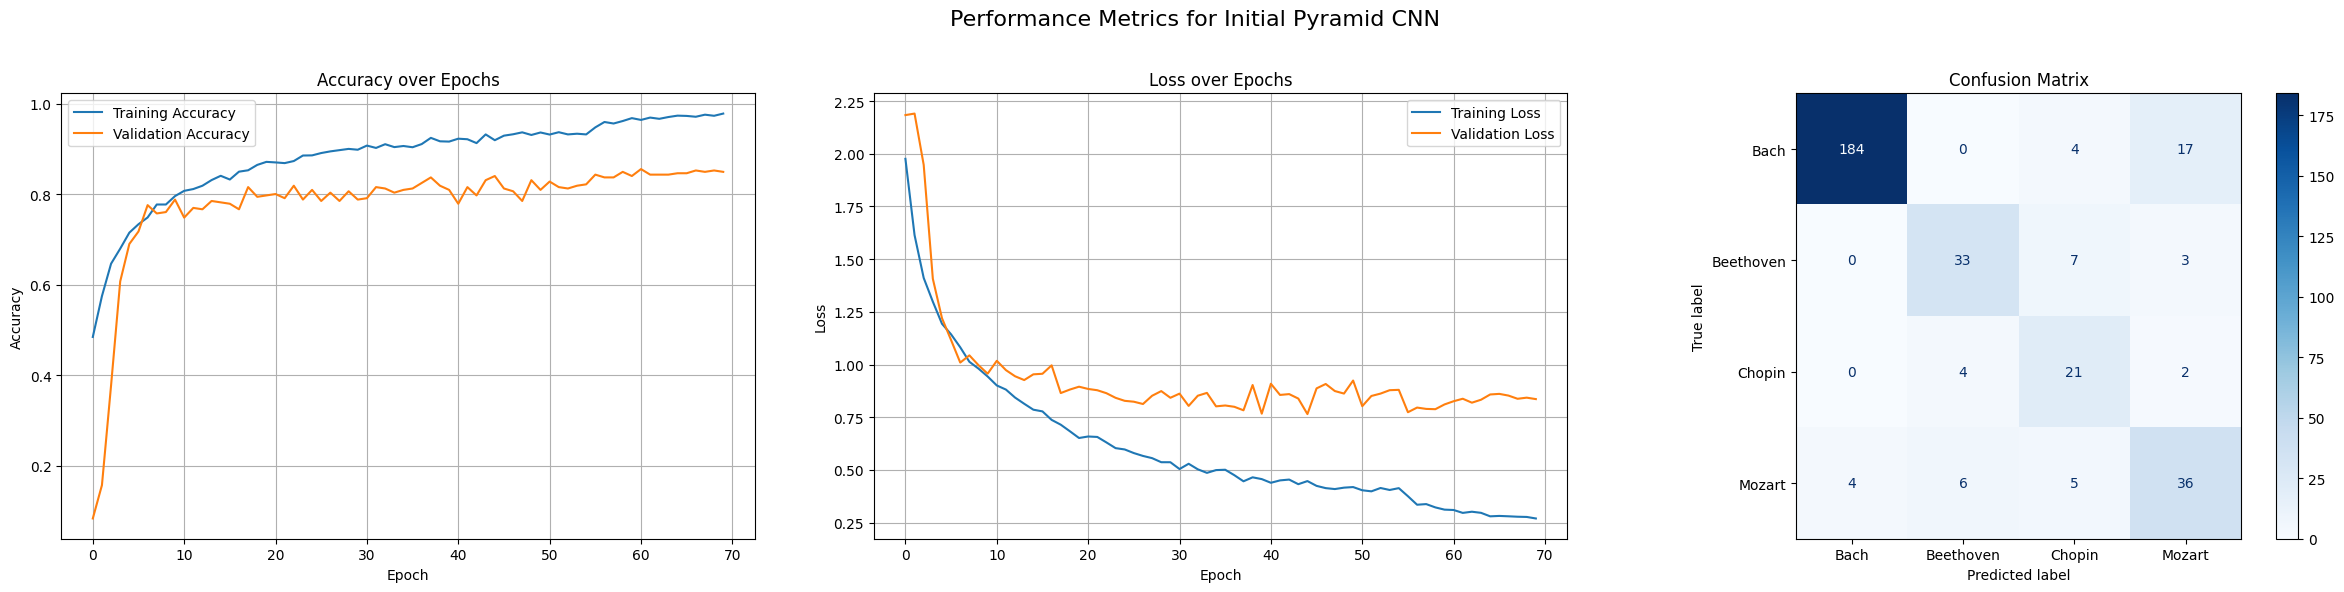

In [ ]:
evaluate_model(custom_model, history_custom, X_test_cnn1d, y_test_encoded, "Initial Pyramid CNN")

 **Learning Progression (in Plots):** The model demonstrates effective learning. The training accuracy (blue line) steadily increases while the training loss decreases, indicating that the model is successfully finding patterns in the training data. The validation curves (orange lines) follow a similar positive trend, confirming that the model is generalizing to the unseen test data.

 After approximately 20 epochs, a noticeable gap emerges between the training and validation curves. The training loss continues to decrease, but the validation loss flattens out. This is sign of *overfitting*.

 #### Evaluation Metrics Analysis (Classification Report & Confusion Matrix)
- **Overall Performance (Accuracy: 84.1%)**: The model achieves a strong baseline accuracy of 84.1%. This confirms that the general CNN architecture is well-suited for this classification task.

- **Per-Class Performance (Report & Confusion Matrix)**:
  - **Bach (High Precision, Good Recall)**: The model is excellent at identifying Bach, with a near-perfect precision of 98% and a solid recall of 90%. This means when it predicts Bach, it's almost always correct.
  - **Beethoven (Balanced)**: Performance on Beethoven is balanced, with both precision and recall at 77%. The confusion matrix shows it correctly identifies 33 of 43 pieces.
  - **Chopin & Mozart (Weak Precision)**: These two composers are the model's primary weakness. While recall is decent (78% for Chopin, 71% for Mozart), the precision is low (57% for Chopin, 62% for Mozart).
  
The initial model is a strong proof-of-concept but suffers from significant overfitting. The primary goal for optimization is to improve generalization by introducing stronger regularization to close the gap between training and validation performance, and hopefully, improve the low precision on the Chopin and Mozart classes.

**Next Steps**:

 Focus on improving generalization by experimenting with different architectures and applying stronger regularization techniques (such as increased dropout or L2 penalties) to close the gap between training and validation performance.

## Model Optimization

To optimize model, we increased the L2 penalty from 0.001 to 0.005 and added additional dropouts.

In [ ]:
def build_tuned_model(input_shape, num_classes, learning_rate=0.001):
    """
    An 'Optimised Pyramid' style CNN
    """
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.3), # Add some dropout early

        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.4), # Increase dropout as we go deeper

        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),

        # Summarization and Classification
        GlobalAveragePooling1D(),

        # Classifier head
        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.5), # Keep the strong dropout

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### Instantiate and Train the optimized Pyramid Model

In [ ]:
print("\n--- Training the optimised Pyramid Model ---")

optimised_pyramid_model = build_tuned_model(
    input_shape=(num_features, 1),
    num_classes=num_classes,
    learning_rate=0.001 # Start with the standard LR
)
optimised_pyramid_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

# Train the model
history_optimised = optimised_pyramid_model.fit(
    X_train_cnn1d, y_train_cat,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_cnn1d, y_test_cat),
    callbacks=[early_stopping, reduce_lr]
)




--- Training the optimised Pyramid Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 11, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 11, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 11, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,908 (390.27 KB)

 Trainable params: 98,692 (385.52 KB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3933 - loss: 4.1587 - val_accuracy: 0.1288 - val_loss: 3.6217 - learning_rate: 0.0010
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4706 - loss: 3.5912 - val_accuracy: 0.1411 - val_loss: 3.5441 - learning_rate: 0.0010
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5143 - loss: 3.2702 - val_accuracy: 0.4847 - val_loss: 3.1251 - learning_rate: 0.0010
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5614 - loss: 2.9623 - val_accuracy: 0.5982 - val_loss: 2.7561 - learning_rate: 0.0010
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5955 - loss: 2.7289 - val_accuracy: 0.6626 - val_loss: 2.4263 - learning_rate: 0.0010
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6154 - loss: 2.4856 - val_accuracy: 0.7239 - val_loss: 2.0881 - learning_rate: 0.0010
Epoch 7/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6391 - l

### Evaluate Tuned Model


--- Final Evaluation of Final Tuned Pyramid CNN ---
Final Test Accuracy: 0.8405
Final Test Loss: 0.6666
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.96      0.90      0.93       205
   Beethoven       0.83      0.67      0.74        43
      Chopin       0.63      0.81      0.71        27
      Mozart       0.59      0.75      0.66        51

    accuracy                           0.84       326
   macro avg       0.75      0.78      0.76       326
weighted avg       0.86      0.84      0.85       326



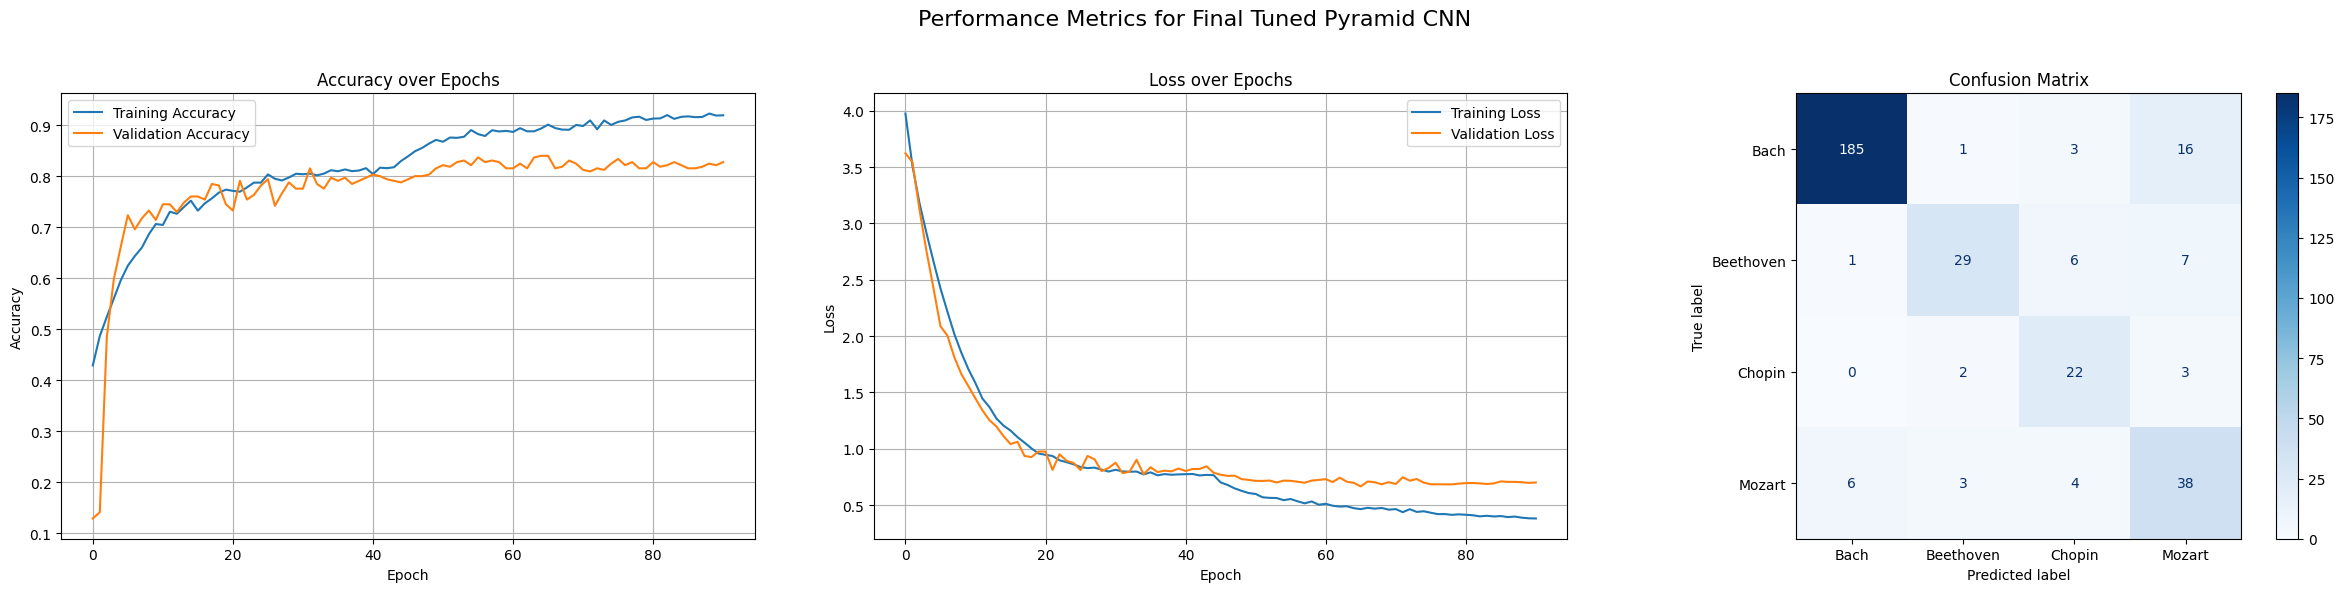

In [ ]:
evaluate_model(optimised_pyramid_model, history_optimised, X_test_cnn1d, y_test_encoded, "Final Tuned Pyramid CNN")

#### Training History Analysis (Accuracy and Loss Curves)

*   **Controlled Learning:** The gap between the training loss (blue) and validation loss (orange) is dramatically smaller than in the initial model. The validation loss tracks the training loss much more closely, confirming that the increased L2 regularization and dropout were highly effective at combating overfitting. The final validation loss of 0.67 is substantially lower than the initial model's 0.77, indicating a more confident and better-generalized model.
*   **Stable Convergence:** The validation curves are much smoother and more stable, showing that the model's performance on unseen data is less erratic during training.

#### Evaluation Metrics Analysis (Classification Report & Confusion Matrix)

- **Overall Performance (Accuracy: 84.1%)**: Interestingly, the overall accuracy remains at 84.1%, identical to the initial model. However, the underlying metrics reveal a healthier, more robust classifier.
Per-Class Performance *(Improved Balance)*:

  - **Bach (Maintains Excellence)**: Performance on Bach remains top-tier with 96% precision and 90% recall.
  - **Beethoven (Precision Boost)**: The model shows a marked improvement in classifying Beethoven. Precision increased significantly from 77% to 83%. This means that when the model now predicts "Beethoven," it is much more likely to be correct, even though its recall slightly decreased. This is a positive trade-off, indicating a more discerning model.
  - **Chopin (Clear Improvement)**: Chopin, a weak point in the first model, saw improvements in both metrics. Precision rose from 57% to 63%, and recall increased from 78% to 81%. This results in a higher F1-score (0.71 vs 0.66), showing a clear net benefit from the tuning.
  - **Mozart (Recall Improvement)**: While precision for Mozart saw a slight dip, its recall improved from 71% to 75%.

  Despite having the same top-line accuracy, the Tuned Pyramid CNN is unequivocally the superior model. It successfully mitigates overfitting, achieves a lower final validation loss, and demonstrates a more balanced and reliable performance across the individual classes, particularly by improving the precision for Beethoven and the overall score for Chopin. This model is more robust and would be expected to perform better on new, real-world data.

In [ ]:
# saving the model for future use
model_save_path = os.path.join(OUTPUT_DIR, 'final_composer_model.keras')

# 2. Save the entire model to this file.
optimised_pyramid_model.save(model_save_path)

print(f"\n✅ Model successfully saved to: {model_save_path}")



✅ Model successfully saved to: project_output/final_composer_model.keras


## Model Building - LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_custom_lstm_model(input_shape, num_classes, learning_rate=0.001):
    """
    A custom-designed LSTM model with pyramid-style dense layers.
    """
    model = Sequential([
        Input(shape=input_shape),

        # LSTM Block 1
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        BatchNormalization(),

        # LSTM Block 2
        LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        # Dense Classifier
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage
custom_lstm_model = build_custom_lstm_model(
    input_shape=(50, 1),  # e.g., (50, 1) for pitch sequences
    num_classes=num_classes,
    learning_rate=0.001
)

custom_lstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,452 (720.52 KB)

 Trainable params: 183,300 (716.02 KB)

 Non-trainable params: 1,152 (4.50 KB)

## Train the LSTM

In [ ]:
# Define sequence_length with an appropriate value
# Replace the placeholder value (e.g., 50) with the actual sequence length of your data
sequence_length = 50  # Placeholder value

# Define y from feature_df
y = feature_df['composer']

# Define label_encoder and num_classes
label_encoder = LabelEncoder()
label_encoder.fit(y) # Fit the encoder to the full dataset to ensure all classes are included
num_classes = len(label_encoder.classes_)

# Now, the build_custom_lstm_model function call should work
custom_lstm_model = build_custom_lstm_model(
    input_shape=(sequence_length, 1),  # e.g., (50, 1) for pitch sequences
    num_classes=num_classes,
    learning_rate=0.001
)

custom_lstm_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,452 (720.52 KB)

 Trainable params: 183,300 (716.02 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# Treat each feature as a timestep with 1 feature per step
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)

custom_lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("\n--- Preparing Data for LSTM ---")

# Reshape input for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

print("\n--- Building the Custom-Designed LSTM Model ---")

# Define the LSTM model
custom_lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')  # Use 'sigmoid' if binary classification
])

custom_lstm_model.compile(
    loss='categorical_crossentropy',  # Use 'binary_crossentropy' if binary classification
    optimizer='adam',
    metrics=['accuracy']
)

print("\n--- Training the Custom-Designed LSTM Model ---")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

# Train the model
history_lstm = custom_lstm_model.fit(
    X_train_lstm, y_train_cat,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_cat),
    callbacks=[early_stopping, reduce_lr]
)


--- Preparing Data for LSTM ---

--- Building the Custom-Designed LSTM Model ---

--- Training the Custom-Designed LSTM Model ---
Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3748 - loss: 1.3185 - val_accuracy: 0.5583 - val_loss: 1.1617 - learning_rate: 0.0010
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4843 - loss: 1.1808 - val_accuracy: 0.6012 - val_loss: 1.0392 - learning_rate: 0.0010
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5261 - loss: 1.0872 - val_accuracy: 0.6196 - val_loss: 0.9846 - learning_rate: 0.0010
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5902 - loss: 1.0187 - val_accuracy: 0.6319 - val_loss: 0.9350 - learning_rate: 0.0010
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6318 - loss: 0.9542 - val_accuracy: 0.6472 - val_loss: 0.8833 - learning_rate: 0.0010
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6524 - loss: 0.8988 - val_accuracy

## Evaluate LSTM Model

In [ ]:
print("\n--- Evaluating the Custom-Designed LSTM Model ---")

# Evaluate on test data
test_loss, test_accuracy = custom_lstm_model.evaluate(X_test_lstm, y_test_cat, verbose=1)

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities
y_pred_probs = custom_lstm_model.predict(X_test_lstm)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\n--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes))

# Print confusion matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_true_classes, y_pred_classes))




--- Evaluating the Custom-Designed LSTM Model ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8310 - loss: 0.5371 
Test Loss     : 0.5311
Test Accuracy : 0.8313
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       205
           1       0.64      0.67      0.66        43
           2       0.63      0.81      0.71        27
           3       0.64      0.71      0.67        51

    accuracy                           0.83       326
   macro avg       0.72      0.77      0.74       326
weighted avg       0.85      0.83      0.84       326


--- Confusion Matrix ---
[[184   6   2  13]
 [  1  29   9   4]
 [  1   1  22   3]
 [  4   9   2  36]]


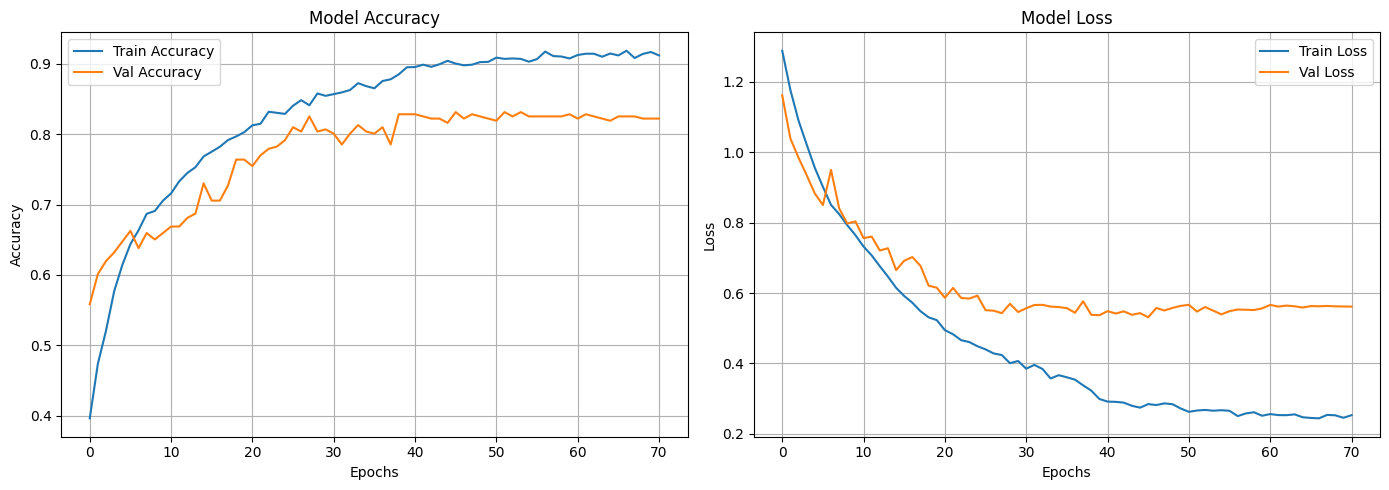

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


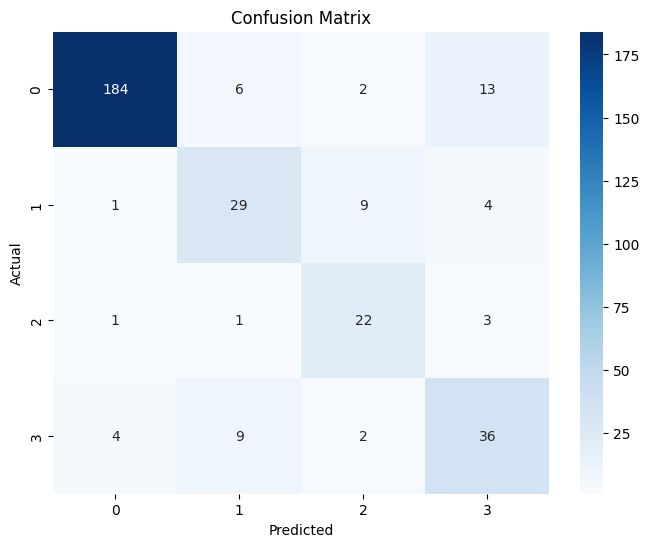


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       205
           1       0.64      0.67      0.66        43
           2       0.63      0.81      0.71        27
           3       0.64      0.71      0.67        51

    accuracy                           0.83       326
   macro avg       0.72      0.77      0.74       326
weighted avg       0.85      0.83      0.84       326



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Accuracy & Loss Plots ---
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Confusion Matrix & Classification Report ---
def plot_confusion_matrix(model, X_test, y_test_cat):
    # Predict class probabilities
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test_cat, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_true_classes, y_pred_classes))

# --- Call the functions ---
plot_training_history(history_lstm)
plot_confusion_matrix(custom_lstm_model, X_test_lstm, y_test_cat)

### LSTM Model Optimization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_tuned_lstm_model(input_shape, num_classes, learning_rate=0.001):
    """
    Optimized LSTM model with regularization and dropout
    """
    model = Sequential([
        Input(shape=input_shape),

        # LSTM stack with increasing capacity and dropout
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.4),

        LSTM(256, kernel_regularizer=l2(0.005)),
        BatchNormalization(),

        # Classifier head
        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
print("\n--- Reshaping Data for LSTM ---")

# Reshape input for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

print("\n--- Instantiating the Optimized LSTM Model ---")

# Define input shape and number of classes
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
num_classes = y_train_cat.shape[1]  # One-hot encoded output

# Instantiate the model
optimized_lstm_model = build_tuned_lstm_model(input_shape, num_classes, learning_rate=0.001)

print("\n--- Training the Optimized LSTM Model ---")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

# Train the model
history_optimized_lstm = optimized_lstm_model.fit(
    X_train_lstm, y_train_cat,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_cat),
    callbacks=[early_stopping, reduce_lr]
)


--- Reshaping Data for LSTM ---

--- Instantiating the Optimized LSTM Model ---

--- Training the Optimized LSTM Model ---
Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3566 - loss: 5.7601 - val_accuracy: 0.0828 - val_loss: 5.2760 - learning_rate: 0.0010
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4381 - loss: 4.9081 - val_accuracy: 0.0828 - val_loss: 4.9000 - learning_rate: 0.0010
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4661 - loss: 4.2850 - val_accuracy: 0.1472 - val_loss: 4.5190 - learning_rate: 0.0010
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5332 - loss: 3.6592 - val_accuracy: 0.1933 - val_loss: 4.1626 - learning_rate: 0.0010
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5781 - loss: 3.1628 - val_accuracy: 0.3865 - val_loss: 3.2176 - learning_rate: 0.0010
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6084 - loss: 2.7886 - val_accuracy: 0.

### Evaluate Optimized LSTM Model


--- Evaluating the Optimized LSTM Model ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8369 - loss: 0.8111
Test Loss     : 0.7999
Test Accuracy : 0.8374
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Classification Report ---
              precision    recall  f1-score   support

        Bach       0.96      0.90      0.93       205
   Beethoven       0.66      0.81      0.73        43
      Chopin       0.69      0.81      0.75        27
      Mozart       0.64      0.63      0.63        51

    accuracy                           0.84       326
   macro avg       0.74      0.79      0.76       326
weighted avg       0.85      0.84      0.84       326



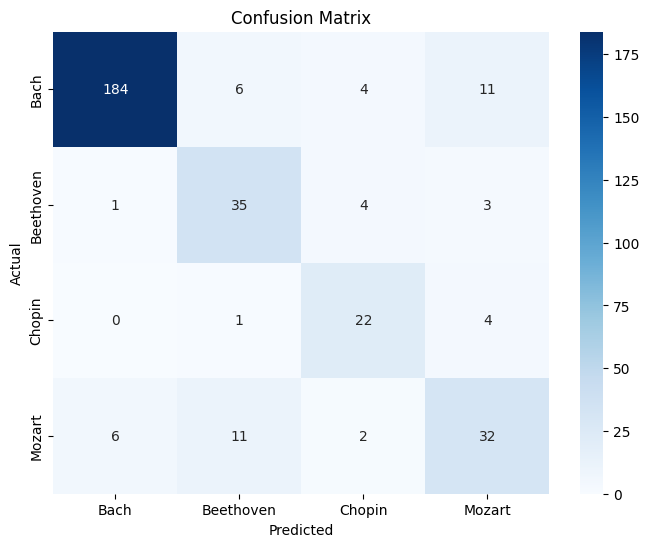

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Evaluating the Optimized LSTM Model ---")

# Evaluate on test data
test_loss, test_accuracy = optimized_lstm_model.evaluate(X_test_lstm, y_test_cat, verbose=1)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

# Predict class probabilities
y_pred_probs = optimized_lstm_model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=TARGET_COMPOSERS))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TARGET_COMPOSERS, yticklabels=TARGET_COMPOSERS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Summary of the comparison:

**Overall Accuracy:**

Tuned CNN: ~84.05%

Optimized LSTM: ~83.74%

Both models achieved very similar overall accuracy on the test set.

**Training Performance and Overfitting:**

Tuned CNN: The training curves show that the regularization (increased L2 and dropout) helped reduce the gap between training and validation performance compared to the initial CNN, indicating better generalization.
Optimized LSTM: The training curves for the optimized LSTM also show a reasonable gap between training and validation, suggesting that the regularization is helping. However, the validation loss seems to fluctuate a bit more compared to the tuned CNN.
Per-Class Performance (from Classification Reports and Confusion Matrices):

**Bach:** Both models perform exceptionally well on the 'Bach' class, with high precision and recall (around 90-97%). This is likely due to Bach being the majority class in the original dataset, even after SMOTE.

**Beethoven:**
Tuned CNN: Showed a significant improvement in precision (83%) for Beethoven after tuning.
Optimized LSTM: Has a slightly lower precision (66%) but higher recall (81%) for Beethoven compared to the tuned CNN. The LSTM seems to be better at identifying Beethoven when it's present but also has more false positives.

**Chopin:**
Tuned CNN: Had a precision of 63% and recall of 81%.
Optimized LSTM: Also shows decent performance with a precision of 69% and recall of 81%. Both models perform similarly here, with the LSTM having slightly better precision.

**Mozart:**
Tuned CNN: Had a precision of 59% and recall of 75%.
Optimized LSTM: Shows similar performance with a precision of 64% and recall of 63%. Both models still show some confusion with other classes for Mozart.

**Key Differences:**

The Tuned CNN seems to have a slight edge in overall consistency and potentially better precision for the 'Beethoven' class. The regularization appears to have been quite effective in balancing performance and reducing overfitting for the CNN architecture on this feature set.
The Optimized LSTM shows strong recall across multiple classes, especially for 'Beethoven' and 'Chopin', but its precision for the minority classes is slightly lower than the tuned CNN. It might be slightly more prone to false positives for Beethoven and Mozart.
Conclusion:

Both the Tuned CNN and the Optimized LSTM models achieved good performance on this task after addressing the class imbalance with SMOTE and applying regularization. The Tuned CNN appears to be marginally better, particularly in achieving higher precision for the 'Beethoven' class, while maintaining a similar overall accuracy. The more stable validation loss of the tuned CNN also suggests it might be slightly more robust.

**For this specific feature set and task, the CNN architecture seems to be slightly more effective at capturing the discriminative patterns in the musical features.**